<br>
<p style="font-size:30px; color: #3776ab; text-align:center"><b>
Big Bang Nucleosynthesis
<b></p>
    
   <p style="font-size:15px;color: #3776ab; text-align:center"><b>
Notebook by: Eva Westenfelder Gil, Julian Rohloff

In this notebook we will visualize the nuclear processes that took place during the first minutes after the big bang. For that we solve the differential equations for the posible reactions during that time period. The evolution of the abundances are then visualized, first as a function of temperature and then as function of time. 

We also visualize the abundances for $4 Y_{{}^4 \mathrm{He}}$,$\frac{Y_{d}}{Y_{p}}$ and $\frac{Y_{{}^7 \mathrm{Li}}}{Y_{p}}$ by $0.1\,GK$ as a function of of the nucleon-to-photon ratio $\eta$ in the range $1 \times 10^{-10}$ to $10 \times 10^{-10}$

In [87]:
from mendeleev import element
from mendeleev import isotope
import scipy as sci
from scipy.integrate import solve_ivp
import scipy.constants as constant
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, animation
from matplotlib.animation import FuncAnimation
from IPython.display import Video


First of all we imported all the necesary python libraries to solve the equations and visualize the abundances

## Constants

In [2]:
# Parameters for the calculation of the reaction rates
SIGV_PARAMS = [
    # [a1, a2, a3, a4, a5, a6, a7]
    [-38.5922, -0.00630249, 1.25159, -8.86637, 1.78419, -0.198181, 1.92028], # Reaction 2
    [-46.8616, -0.00295519, -3.23527, 1.42088, -0.126344, 0.00974799, -0.178045], # Reaction 3
    [-42.1159, 0.0101979, -6.1653, 10.9227, -0.654152, 0.0352096, -3.41782], # Reaction 4
    [-43.1056, 0.0150095, -6.85042, 12.3633, -0.638696, 0.0261701, -4.16095], # Reaction 5
    [-34.1675, -0.523, 4.63833e-10, -1.67345e-9, 1.85876e-10, -1.70346e-11, -0.666667], # Reaction 6
    [-31.7974, -0.0137498, -5.56986, -14.1977, 2.27582, -0.19545, 2.92443], # Reaction 7
    [-34.1075, -0.000673532, 0.0793345, -0.532712, 0.13522, -0.00748114, 0.104904], # Reaction 8
    [-34.8617, -1.72, -4.68818e-9, 1.21488e-8, -1.10092e-9, 8.94955e-11, -0.5], # Reaction 9
    [-38.9414, -0.000245919, -12.7758, -0.489479, -0.0881085, 0.00557341, -0.582926], # Reaction 10
    [-32.5903, -0.0032998, -7.83923, -2.1531, 0.133483, -0.00732414, 0.20178], # Reaction 11
    [-32.3946, 9.06317e-7, -2.04247e-9, -1.167, -4.39104e-10, 3.41812e-11, -1.98589e-9] # Reaction 12
]



In [3]:
#Konstanten
#Temperatur in GK
#Masse in MeV
kB=0.0861734 #in MeV/GK
kBG=0.0861734 *10**(-3) #in GeV/GK
hsc=1.97327 * 10**(-11) #in MeV*cm
hscG=hsc*10**(-3) #in GeV*cm
c=sci.constants.c #in cm/s
pi=sci.constants.pi
muc2= 931.494 # in MeV
lambda_beta=0.00113443 #in s^-1
eta=6.2 * 10**(-10) #dimensionless
delta_mc2=1.293 #in MeV

## Hilfsmitteln und Isotope+Neutron Werte

In [4]:
def contains_slash(string): #To write spin from mendeleev to floats
    if "/" in string:
        return True
    else:
        return False

def Spin_to_float(j):
    if (contains_slash(j)==True):
        # Split the string into two parts using the forward slash
        parts = j.split("/")
        # Convert the numerator and denominator to floats
        numerator = float(parts[0])
        denominator = float(parts[1])
        # Divide the numerator by the denominator
        result = numerator / denominator
        return result
    
    else:
        return float(j)

In [5]:
class Particle:
    def __init__(self,mass,Z,A,j,number):
        self.mass = mass *muc2
        self.Z = Z
        self.A = A
        self.spin = Spin_to_float(j)
        self.number=number

In [6]:
def kron_delta(part1,part2): #kroenecker delta for a and b
    if part1.number == part2.number:
        return 1
    else:
        return 0

In [7]:
neutron=Particle(1.00866491595, 0,1,'1/2',0)
H1= Particle(isotope(1, 1).mass,1,1,isotope(1, 1).spin,1) 
H2= Particle(isotope(1, 2).mass,1,2,isotope(1, 2).spin,2)
H3=Particle(isotope(1, 3).mass,1, 3,isotope(1, 3).spin,3)
He3=Particle(isotope(2, 3).mass,2, 3,isotope(2, 3).spin,4)
He4=Particle(isotope(2, 4).mass,2, 4,isotope(2, 4).spin,5)
Li7=Particle(isotope(3, 7).mass,3, 7,isotope(3, 7).spin,6)
Be7=Particle(isotope(4, 7).mass,4, 7,isotope(4,7).spin,7)

#Just in case it becomes more comfortable to write them like this:
n=neutron
p=H1 
d=H2
t=H3
al=He4

List_Isotopes=[neutron,H1,H2,H3,He3,He4,Li7,Be7]


In [8]:
YnYp = np.exp(-delta_mc2/(kB*9))
Yp0= 1 /(1+YnYp)
Yn0=YnYp* Yp0


In [9]:
Y_n0=Yn0 
Y_H10=Yp0
Y_H20=0
Y_H30=0
Y_He30=0
Y_He40=0
Y_Li70=0
Y_Be70=0


Menge_liste=[Y_n0,Y_H10,Y_H20,Y_H30,Y_He30,Y_He40,Y_Li70,Y_Be70]


## Nicht-Differentialgleichungen

In [10]:
def T_value(t):
    return 14.0/(t**(1/2))


def n_Variable(T): #T in GK 
    return eta*(2*sci.special.zeta(3)*(kB*T)**3)/(np.pi**2 *hsc**3)#in cm**-3


def n_eta(T,eta_value): #T in GK 
    return eta_value*(2*sci.special.zeta(3)*(kB*T)**3)/(np.pi**2 *hsc**3)#in cm**-3


In [11]:
def ov_T(T,r_number): #T in GK, ov in cm**3/s**-1
    a1, a2,a3,a4,a5,a6,a7=SIGV_PARAMS[r_number-2]#Since the first (1st) reaction beta decay is, the parameters for the 2nd reaction are saved in [0]
    return np.exp(a1 + a2/T + a3*T**(-1/3) + a4*T**(1/3) + a5*T +a6*T**(5/3) + a7*np.log(T)) 

def lambda_gamma(T,part1,part2,part3,r_number):#T in GK
    Term1=(muc2*kB*T/(2*pi**2 * hsc**2))**(3/2) #muc2*kB*T in MeV**2 , hsc**2 in (in MeV*cm)**2 #dimensionless

    Term2=(2*part1.spin +1)*(2*part2.spin +1)/(2*part3.spin +1) #dimensionless

    Term3=(part1.A*part2.A/part3.A)**(3/2) #dimensionless

    Q=(part1.mass + part2.mass - part3.mass) # in MeV 
    
    Term4=np.exp(-Q/(kB*T)) #Q in MeV, (kB*T) in MeV    dimensionless
    
    Term5=ov_T(T,r_number)/(1+kron_delta(part1,part2))
    
    tog=Term1*Term2*Term3*Term4*Term5  #in cm**3/s**-1
    return tog


In [12]:
def ov_cd(T,part1,part2,part3,part4,r_number):
    Term1=(1+kron_delta(part3,part4))/(1+kron_delta(part1,part2))#dimensionless 
    Term2=(2*part1.spin +1)*(2*part2.spin +1)/((2*part3.spin +1)*(2*part4.spin +1))#dimensionless 
    Term3=(part1.A*part2.A/(part3.A*part4.A))**(3/2)#dimensionless 
    Q=(part1.mass + part2.mass - part3.mass - part4.mass)*muc2 #in MeV
    Term4=np.exp(-Q/(kB*T)) #dimensionless
    tog=Term1*Term2*Term3*Term4* ov_T(T,r_number)#dimensionless
    return tog

In [13]:
def r_number_to_reaction_particles(r_number):
    if r_number == 1:
        return [neutron, 0, H1, 0]
    elif r_number==2:
        return [p,n,H2,0]
    elif r_number==3:
        return [d,p,He3,0]
    elif r_number==4:
        return [d,d,n,He3]
    elif r_number==5:
        return [d,d,p,H3]
    elif r_number==6:
        return [t,d,n,He4]
    elif r_number==7:
        return [t,al,Li7,0]
    elif r_number==8:
        return [He3,n,p,t]
    elif r_number==9:
        return [He3,d,p,He4]
    elif r_number==10:
        return [He3,al,Be7,0]
    elif r_number==11:
        return [Li7,p,al,He4]
    elif r_number==12:
        return [Be7,neutron,p,Li7]
    else:
        print("Not a valid reaction number")
        return [0,0,0,0]


## Differentialgleichungen

In [14]:
def dt_to_dT(T):
    return -T**3 /392,0 

In [15]:
def drv_beta_decay(N_liste): #Das ist für dydt
    Ya=N_liste[0]
    Yc=N_liste[1]
    return [-Ya*lambda_beta, Ya*lambda_beta]


In [16]:
def drv_gammapart(T,N_liste,part1,part2,part3,r_number): #Das ist für dydt     
    Ya = N_liste[part1.number]
    Yb = N_liste[part2.number]
    Yc = N_liste[part3.number]
    dYa=-Ya*Yb*n_Variable(T)*ov_T(T,r_number)+(1+kron_delta(part1,part2))*lambda_gamma(T,part1,part2,part3,r_number)*Yc
    dYb=-Ya*Yb*n_Variable(T)*ov_T(T,r_number)+(1+kron_delta(part1,part2))*lambda_gamma(T,part1,part2,part3,r_number)*Yc
    dYc=Ya*Yb*n_Variable(T)*ov_T(T,r_number)/(1+kron_delta(part1,part2))-lambda_gamma(T,part1,part2,part3,r_number)*Yc
    return np.array([dYa, dYb, dYc])

In [17]:
def drv_fourthpart(T,N_liste,part1,part2,part3,part4,r_number): #Das ist für dydt
    Ya = N_liste[part1.number]
    Yb = N_liste[part2.number]
    Yc = N_liste[part3.number]
    Yd = N_liste[part4.number]
    Term1 =-Ya * Yb * n_Variable(T) * ov_T(T,r_number)
    Term2 = (1 + kron_delta(part1, part2)) / (1 + kron_delta(part3, part4)) *  n_Variable(T) * Yc * Yd * ov_cd(T,part1, part2, part3, part4,r_number)
    Term3 = (1 + kron_delta(part3, part4)) / (1 + kron_delta(part1, part2)) * Ya * Yb * n_Variable(T) * ov_T(T,r_number)
    Term4 =-Yc * Yd * ov_cd(T,part1, part2, part3, part4,r_number) *  n_Variable(T) 
    
    dYa=Term1+Term2
    dYb=Term1+Term2
    dYc=Term3+Term4
    dYd=Term3+Term4
    
    return np.array([dYa, dYb, dYc,dYd])

In [18]:
def master_equation_for_dT(T, N_liste):
    dY_liste = [0, 0, 0, 0, 0, 0, 0, 0]
    
    for i in range(1, 13): #if i in range(1, n>8) Error message 
        particles = r_number_to_reaction_particles(i)
        r_number = i
        
        if i == 1:
            dY_beta=drv_beta_decay(N_liste)
            dY_liste[0] =dY_liste[0] + -392 / (T ** 3) * dY_beta[0] 
            dY_liste[1] =dY_liste[1] + -392 / (T ** 3) * dY_beta[1]

        else:
            if particles[3] == 0:
                dY_gamma=drv_gammapart(T, N_liste, particles[0], particles[1], particles[2], r_number)
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                
                dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_gamma[0]
                dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_gamma[1]
                dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_gamma[2]
            else:
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                num_d=particles[3].number
                dY_four_particles=drv_fourthpart(T, N_liste, particles[0], particles[1], particles[2], particles[3], r_number)
                
                if particles[0].number == particles[1].number :
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + -392 / (T ** 3) * dY_four_particles[3]

                elif particles[2].number == particles[3].number:
                    dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                
                else:
                    dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + -392 / (T ** 3) * dY_four_particles[3]

    return dY_liste



In [19]:
T_span=[9,0.1]

r_tol = 1e-10
a_tol = 1e-10
sol_dT = solve_ivp(master_equation_for_dT, T_span, Menge_liste, method="BDF",max_step=0.01, atol=a_tol,rtol=r_tol)

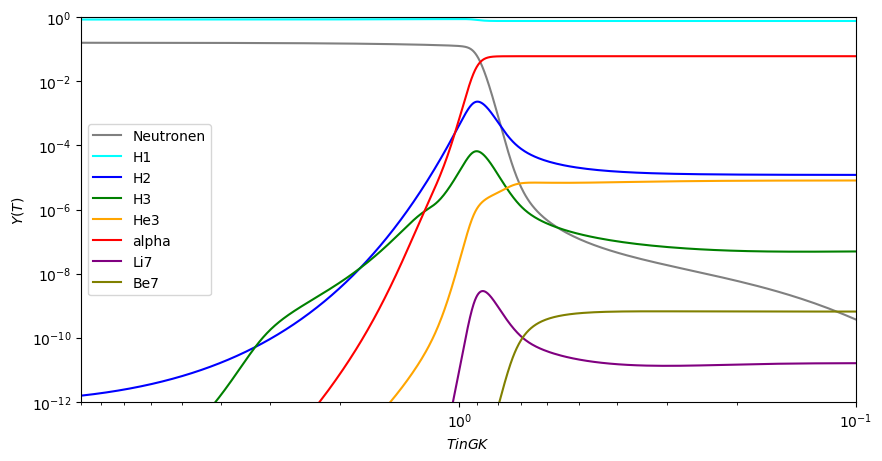

In [20]:
plt.figure(figsize = (10, 5))
plt.xlabel("$T in GK$")
plt.ylabel("$Y(T)$")
plt.plot(sol_dT.t, sol_dT.y[0], label = "Neutronen", color="grey")
plt.plot(sol_dT.t, sol_dT.y[1], label = "H1", color="cyan")
plt.plot(sol_dT.t, sol_dT.y[2], label = "H2", color="blue")
plt.plot(sol_dT.t, sol_dT.y[3], label = "H3", color="green")
plt.plot(sol_dT.t, sol_dT.y[4], label = "He3", color="orange")
plt.plot(sol_dT.t, sol_dT.y[5], label = "alpha", color="red")
plt.plot(sol_dT.t, sol_dT.y[6], label = "Li7", color="purple")
plt.plot(sol_dT.t, sol_dT.y[7], label = "Be7", color="olive")

plt.xlim(9, 0.1)
plt.ylim(10**-12,1)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [21]:
x=sol_dT.t

Y_n=sol_dT.y[0]
Y_H1=sol_dT.y[1]
Y_H2=sol_dT.y[2]
Y_H3=sol_dT.y[3]
Y_He3=sol_dT.y[4]
Y_He4=sol_dT.y[5]
Y_Li7=sol_dT.y[6]
Y_Be7=sol_dT.y[7]

x1=[]

Yn=[]
YH1=[]
YH2=[]
YH3=[]
YHe3=[]
YHe4=[]
YLi7=[]
YBe7=[]

In [61]:
found=False
for i in range (0,len(x)):
    if found ==False:
        for j in range(2,8):
            if sol_dT.y[j][i]>10**(-12):
                print(sol_dT.t[i],j)
                found=True
    

8.99999999999994 2


In [59]:
print(Y_H2[2],sol_dT.t[2])

1.3102099656155363e-12 8.99999999999994


In [30]:
plt.close()

fig, axes = plt.subplots()


axes.set_xlim(9, 0.1)
axes.set_ylim(10 ** -12, 1)
axes.set_xlabel("Time")
axes.set_ylabel("Value")
plt.yscale('log')
plt.xscale('log')
axes.legend()



line0,=axes.plot([])
line1,=axes.plot([])
line2,=axes.plot([])
line3,=axes.plot([])
line4,=axes.plot([])
line5,=axes.plot([])
line6,=axes.plot([])
line7,=axes.plot([])

line0.set_xdata(x)
line0.set_ydata(y)

def drawframe(frame_number):
    line.set_xdata(x)
    line.set_ydata(Y_n[frame_number])
    
    line.set_xdata(x)
    line.set_ydata(Y_H1[frame_number])
    
    line.set_xdata(x)
    line.set_ydata(Y_H2[frame_number])
    
    line.set_xdata(x)
    line.set_ydata(Y_H3[frame_number])
    
    line.set_xdata(x)
    line.set_ydata(Y_He3[frame_number])

    line.set_xdata(x)
    line.set_ydata(Y_He4[frame_number])
    
    line.set_xdata(x)
    line.set_ydata(Y_Li7[frame_number])
    
    line.set_xdata(x)
    line.set_ydata(Y_Be7[frame_number])
    
    return line

anim = animation.FuncAnimation(fig, drawframe, frames=len(x), interval=20)

# Save the animation as an mp4. This requires ffmpeg or mencoder to be installed.
anim.save('videos/aaaaaa.mp4', fps=30)
plt.close()

NameError: name 'y' is not defined

Error in callback <function _draw_all_if_interactive at 0x000001EFA8DCFF70> (for post_execute):


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1163,) and arg 1 with shape (0,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1163,) and arg 1 with shape (0,).

<Figure size 640x480 with 1 Axes>

In [48]:
plt.close()

fig, axes = plt.subplots()
plt.style.use("ggplot")


def drawframe(frame_number):
    x1.append(x[i])
    Yn.append(Y_n[i])
    YH1.append(Y_H1[i])
    YH2.append(Y_H2[i])
    YH3.append(Y_H3[i])
    YHe3.append(Y_He3[i])
    YHe4.append(Y_He4[i])
    YLi7.append(Y_Li7[i])
    YBe7.append(Y_Be7[i])

    axes.clear()  # Clear the plot before drawing new lines
    axes.plot(x1, Yn, label="Neutronen", color="grey")
    axes.plot(x1, YH1, label="H1", color="cyan")
    axes.plot(x1, YH2, label="H2", color="blue")
    axes.plot(x1, YH3, label="H3", color="green")
    axes.plot(x1, YHe3, label="He3", color="orange")
    axes.plot(x1, YHe4, label="alpha", color="red")
    axes.plot(x1, YLi7, label="Li7", color="purple")
    axes.plot(x1, YBe7, label="Be7", color="olive")

    axes.set_xlim(9, 0.1)
    axes.set_ylim(10 ** -12, 1)
    axes.set_xlabel("Time")
    axes.set_ylabel("Value")
    plt.yscale('log')
    plt.xscale('log')
    axes.legend()


anim = anim = animation.FuncAnimation(fig, drawframe, frames=len(x), interval=20)

# Save the animation as an mp4. This requires ffmpeg or mencoder to be installed.
anim.save('videos/aaaaaa.mp4', fps=30)
plt.close()

# Für dt jetzt

In [32]:
def T_value(t):
    return 14.0/(t**(1/2))


def t_Value(T):
    return (T/14.0)**-2

t_min=t_Value(9)
t_max= t_Value(0.1)
t_span=[t_min,t_max]
t_span

#t_Value(9)

[2.4197530864197527, 19599.999999999996]

In [33]:
def master_equation_for_dt(t, N_liste):
    dY_liste = [0, 0, 0, 0, 0, 0, 0, 0]
    Tdef=T_value(t)
    for i in range(1, 13): #if i in range(1, n>8) Error message 
        particles = r_number_to_reaction_particles(i)
        r_number = i
        
        if i == 1:
            dY_beta=drv_beta_decay(N_liste)
            dY_liste[0] =dY_liste[0] + dY_beta[0] 
            dY_liste[1] =dY_liste[1] + dY_beta[1]

        else:
            if particles[3] == 0:
                dY_gamma=drv_gammapart(Tdef, N_liste, particles[0], particles[1], particles[2], r_number)
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                
                
                dY_liste[num_a] =dY_liste[num_a] + dY_gamma[0]
                dY_liste[num_b] =dY_liste[num_b] + dY_gamma[1]
                dY_liste[num_c] =dY_liste[num_c] + dY_gamma[2]
            else:
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                num_d=particles[3].number
                
                dY_four_particles=drv_fourthpart(Tdef, N_liste, particles[0], particles[1], particles[2], particles[3], r_number)
                
                if particles[0].number == particles[1].number :
                    dY_liste[num_b] =dY_liste[num_b] + dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] +  dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + dY_four_particles[3]

                elif particles[2].number == particles[3].number:
                    dY_liste[num_a] =dY_liste[num_a] + dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + dY_four_particles[2]
                
                else:
                    dY_liste[num_a] =dY_liste[num_a] + dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + dY_four_particles[3]

    return dY_liste



In [86]:
r_tol = 1e-10
a_tol = 1e-10
sol2 = solve_ivp(master_equation_for_dt, t_span, Menge_liste, method="BDF",max_step=0.5, atol=a_tol,rtol=r_tol)

KeyboardInterrupt: 

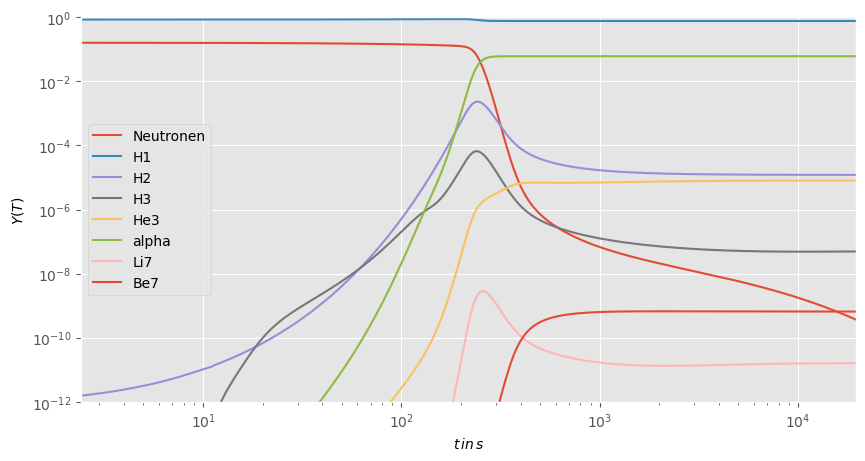

In [36]:
plt.figure(figsize = (10, 5))
plt.xlabel("$t\,in\,s$")
plt.ylabel("$Y(T)$")
plt.plot(sol2.t, sol2.y[0], label = "Neutronen")
plt.plot(sol2.t, sol2.y[1], label = "H1")
plt.plot(sol2.t, sol2.y[2], label = "H2")
plt.plot(sol2.t, sol2.y[3], label = "H3")
plt.plot(sol2.t, sol2.y[4], label = "He3")
plt.plot(sol2.t, sol2.y[5], label = "alpha")
plt.plot(sol2.t, sol2.y[6], label = "Li7")
plt.plot(sol2.t, sol2.y[7], label = "Be7")

plt.xlim(t_min, t_max)
plt.ylim(10**-12,1)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

# Für eta

In [37]:
def drv_gammapart_eta(T, eta_value,N_liste,part1,part2,part3,r_number): #Das ist für dydt     
    Ya = N_liste[part1.number]
    Yb = N_liste[part2.number]
    Yc = N_liste[part3.number]
    dYa=-Ya*Yb*n_eta(T,eta_value)*ov_T(T,r_number)+(1+kron_delta(part1,part2))*lambda_gamma(T,part1,part2,part3,r_number)*Yc
    dYb=-Ya*Yb*n_eta(T,eta_value)*ov_T(T,r_number)+(1+kron_delta(part1,part2))*lambda_gamma(T,part1,part2,part3,r_number)*Yc
    dYc=Ya*Yb*n_eta(T,eta_value)*ov_T(T,r_number)/(1+kron_delta(part1,part2))-lambda_gamma(T,part1,part2,part3,r_number)*Yc
    return np.array([dYa, dYb, dYc])

In [38]:
def drv_fourthpart_eta(T, eta_value,N_liste,part1,part2,part3,part4,r_number): #Das ist für dydt
    Ya = N_liste[part1.number]
    Yb = N_liste[part2.number]
    Yc = N_liste[part3.number]
    Yd = N_liste[part4.number]
    Term1 =-Ya * Yb * n_eta(T,eta_value) * ov_T(T,r_number)
    Term2 = (1 + kron_delta(part1, part2)) / (1 + kron_delta(part3, part4)) * n_eta(T,eta_value) * Yc * Yd * ov_cd(T,part1, part2, part3, part4,r_number)
    Term3 = (1 + kron_delta(part3, part4)) / (1 + kron_delta(part1, part2)) * Ya * Yb * n_eta(T,eta_value) * ov_T(T,r_number)
    Term4 =-Yc * Yd * ov_cd(T,part1, part2, part3, part4,r_number) *  n_eta(T,eta_value) 
    
    dYa=Term1+Term2
    dYb=Term1+Term2
    dYc=Term3+Term4
    dYd=Term3+Term4
    
    return np.array([dYa, dYb, dYc,dYd])

In [39]:
def master_equation_for_eta(T, N_liste,eta_value):
    dY_liste = [0, 0, 0, 0, 0, 0, 0, 0]
    
    for i in range(1, 13): #if i in range(1, n>8) Error message 
        particles = r_number_to_reaction_particles(i)
        r_number = i
        
        if i == 1:
            dY_beta=drv_beta_decay(N_liste)
            dY_liste[0] =dY_liste[0] + -392 / (T ** 3) * dY_beta[0] 
            dY_liste[1] =dY_liste[1] + -392 / (T ** 3) * dY_beta[1]

        else:
            if particles[3] == 0:
                dY_gamma=drv_gammapart_eta(T, eta_value, N_liste, particles[0], particles[1], particles[2], r_number)
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                
                dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_gamma[0]
                dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_gamma[1]
                dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_gamma[2]
            else:
                num_a=particles[0].number #for better visibility
                num_b=particles[1].number
                num_c=particles[2].number
                num_d=particles[3].number
                dY_four_particles=drv_fourthpart_eta(T, eta_value, N_liste, particles[0], particles[1], particles[2], particles[3], r_number)
                
                if particles[0].number == particles[1].number :
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + -392 / (T ** 3) * dY_four_particles[3]

                elif particles[2].number == particles[3].number:
                    dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                
                else:
                    dY_liste[num_a] =dY_liste[num_a] + -392 / (T ** 3) * dY_four_particles[0]
                    dY_liste[num_b] =dY_liste[num_b] + -392 / (T ** 3) * dY_four_particles[1]
                    dY_liste[num_c] =dY_liste[num_c] + -392 / (T ** 3) * dY_four_particles[2]
                    dY_liste[num_d] =dY_liste[num_d] + -392 / (T ** 3) * dY_four_particles[3]

    return dY_liste


In [40]:
eta_span=np.linspace(1*10**(-10),10*10**(-10), num=100, endpoint=True)
len(eta_span)


100

In [41]:
sol_eta = [0 for x in range(100)]

In [42]:

for i in range(0,100):
    
    sol_eta[i] = solve_ivp(master_equation_for_eta, T_span, Menge_liste,args=(eta_span[i],), method="BDF",max_step=0.01, atol=a_tol,rtol=r_tol)

In [43]:
sol_eta

[  message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 9.000e+00  9.000e+00 ...  1.005e-01  1.000e-01]
         y: [[ 1.588e-01  1.588e-01 ...  5.252e-08  5.086e-08]
             [ 8.412e-01  8.412e-01 ...  7.810e-01  7.810e-01]
             ...
             [ 0.000e+00  0.000e+00 ...  2.868e-10  2.868e-10]
             [ 0.000e+00  0.000e+00 ...  1.113e-12  1.113e-12]]
       sol: None
  t_events: None
  y_events: None
      nfev: 2987
      njev: 137
       nlu: 360,
   message: The solver successfully reached the end of the integration interval.
   success: True
    status: 0
         t: [ 9.000e+00  9.000e+00 ...  1.057e-01  1.000e-01]
         y: [[ 1.588e-01  1.588e-01 ...  5.708e-08  4.061e-08]
             [ 8.412e-01  8.412e-01 ...  7.793e-01  7.793e-01]
             ...
             [ 0.000e+00  0.000e+00 ...  2.358e-10  2.358e-10]
             [ 0.000e+00  0.000e+00 ...  1.573e-12  1.571e-12]]
       sol:

In [44]:
y1 = 0.240
y2 = 0.258


y3 = 2.61 *10**(-5)
y4 = 3.03 *10**(-5)


y5 = 1.26 *10**(-10)
y6 = 2.14 *10**(-10)

x=eta_span
yHe4= [0 for x in range(100)]
YdYp=[0 for x in range(100)]
YLiYp=[0 for x in range(100)]

for i in range(0,100):
    yHe4[i]=4*sol_eta[i].y[4][-1]
for i in range(0,100):
    YdYp[i]=sol_eta[i].y[2][-1] / sol_eta[i].y[1][-1]
    
for i in range(0,100):
    YLiYp[i]=sol_eta[i].y[2][-1] / sol_eta[i].y[1][-1]
    



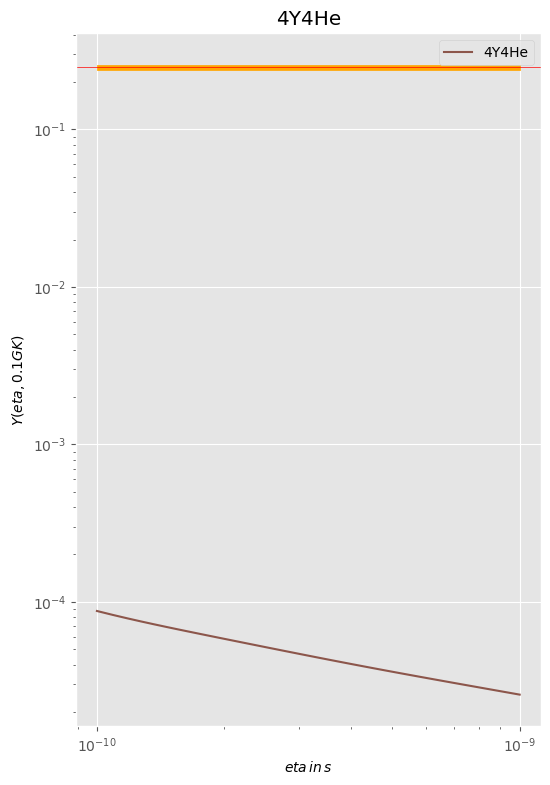

In [47]:
plt.close()

plt.figure(figsize=(6,9))
plt.fill_between(x,y1, y2,color="orange")
plt.axhline(y=0.249, color='r', linestyle='-',linewidth=0.5)
plt.plot(x, yHe4, label = "4Y4He", color='tab:brown')
plt.title('4Y4He')
plt.xlabel("$eta\,in\,s$")
plt.ylabel("$Y(eta,0.1GK)$")


plt.yscale('log')
plt.xscale('log')


plt.legend()
plt.show()

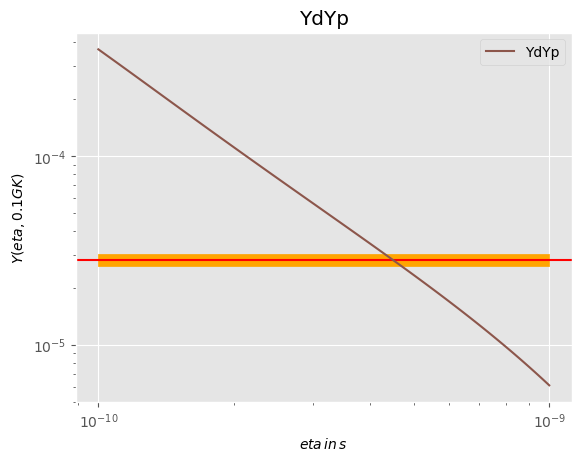

In [72]:
plt.close()

plt.yscale('log')
plt.xscale('log')
plt.axhline(y=2.82*10**(-5), color='r', linestyle='-')
plt.plot(x, YdYp, label = "YdYp", color='tab:brown')
plt.fill_between(x,y3, y4,color="orange")
plt.title('YdYp')
plt.xlabel("$eta\,in\,s$")
plt.ylabel("$Y(eta,0.1GK)$")

plt.legend()
plt.show()

eta_span=np.linspace(1*10**(-10),10*10**(-10), num=100, endpoint=True)

In [81]:
eta_for_YdYp=[]
foundYd=False
for i in range (1,90):
    if foundYd ==False:
        if YdYp[i]< y4:
            if YdYp[i]> y3:
                eta_for_YdYp.append(x[i])
            else:
                foundYd=False
                
eta_for_YdYp

[4.3636363636363644e-10,
 4.454545454545455e-10,
 4.545454545454546e-10,
 4.636363636363637e-10]

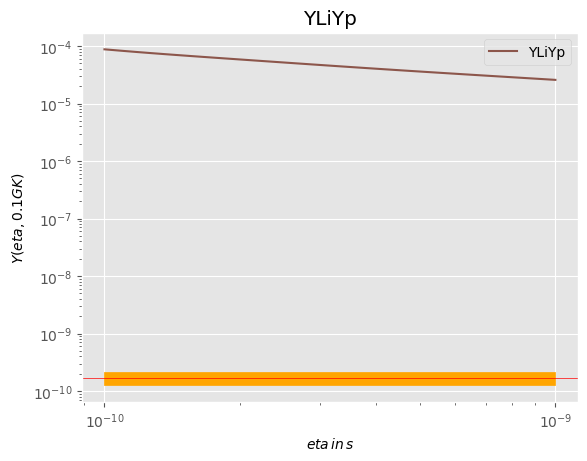

In [82]:
plt.close()

plt.yscale('log')
plt.xscale('log')

plt.plot(x, yHe4, label = "YLiYp", color='tab:brown')
plt.axhline(y= 1.7*10**(-10), color='r', linestyle='-',linewidth=0.5)
plt.fill_between(x,y5, y6, color='orange')
plt.title('YLiYp')
plt.xlabel("$eta\,in\,s$")
plt.ylabel("$Y(eta,0.1GK)$")

plt.legend()
plt.show()
